# LETOR with Microsoft `lightgbm` implementation of `LambdaMART`

This notebook shows how to implement `LambdaMART` with the efficient Microsoft implementation of `xgboost`, `lightgbm`. Here we use this algo first with toy data and next, we translate to the stock ranking problem with monthly rebalancing.

In [2]:
# Importing important libraries
import optuna
import joblib
import numpy as np
import pandas as pd
import lightgbm as lightgbm
import optuna.integration.lightgbm as optuna_lgb

from collections import OrderedDict
from sklearn.model_selection import ParameterGrid

## Toy Ratings

See [Medium Article](https://medium.datadriveninvestor.com/a-practical-guide-to-lambdamart-in-lightgbm-f16a57864f6):

1. **Loading the data** (missing dummy data file, can be easily regenerated with random data)
2. **Splitting the data into train and test** (Custom splitting based on `qid`)
3. **Preparing the data for `LightGBM`**
4. **Training the `LightGBM` `LambdaMART` Model**
5. **Feature Importance**

## Stock Ratings

### 1. Loading the Data

In [6]:
stock_features = pd.read_csv(
    "data/config/20220831_last_enhanced_dataset_monthly.csv",
    parse_dates=["Date"]
).iloc[:,:-1]
stock_features

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217


In [16]:
stock_isharpe_scores = pd.read_csv(
    "data/config/20220831_lagged_isharpe_scores_monthly.csv",
    usecols=["Date","symbols","ISR12M"],
    parse_dates=["Date"]
)

In [17]:
stock_isharpe_scores

,Date,symbols,ISR12M
0,2007-09-28,A,11.0
1,2007-09-28,AA,15.0
2,2007-09-28,AAPL,19.0
3,2007-09-28,ABC,9.0
4,2007-09-28,ABT,13.0
...,...,...,...
83946,2022-07-29,XRX,5.0
83947,2022-07-29,Y,18.0
83948,2022-07-29,YUM,8.0
83949,2022-07-29,ZBH,4.0


Merge features with relevances

In [20]:
df = pd.merge(    
        stock_features,
        stock_isharpe_scores,
    on=["Date","symbols"],
    how="inner"
).rename(columns=
    {
        "ISR12M_x": "ISR12M",
        "ISR12M_y": "relevance"
    }
)
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14.0
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15.0
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19.0
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10.0
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5.0
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18.0
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8.0
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4.0


In [22]:
# Dumping for Archive
df.to_csv(
    "data/config/20220831_letor_stock_monthly_relevances_minimal.csv",
    index=False
)

### 2. Splitting the data intro train and test

In [23]:
df

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
0,2007-10-31,A,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168,14.0
1,2007-10-31,AA,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691,15.0
2,2007-10-31,AAPL,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120,19.0
3,2007-10-31,ABC,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703,10.0
4,2007-10-31,ABT,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,-0.007128,-0.137710,-0.257794,-0.031321,-0.427877,-0.566385,0.162517,-0.085528,-0.090846,0.475500,5.0
83478,2022-07-29,Y,-0.005002,0.303045,0.271664,-0.343658,14.722666,9.332482,-0.000619,1.505580,0.904912,0.188267,18.0
83479,2022-07-29,YUM,0.030349,0.032540,-0.043256,0.242966,0.184209,-0.173151,0.597081,0.375240,-0.009783,0.232148,8.0
83480,2022-07-29,ZBH,-0.112113,-0.058252,-0.295957,-0.759136,-0.278908,-1.001985,-0.129716,-0.021664,-0.075548,0.281217,4.0


In [28]:
train = df[df["Date"]<"2019"]
test = df[df["Date"]>="2019"]

In [29]:
train.shape[0]/df.shape[0]

0.7584269662921348

In [30]:
train.tail(5)

,Date,symbols,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M,relevance
63310,2018-12-31,XRX,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453,8.0
63311,2018-12-31,Y,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673,13.0
63312,2018-12-31,YUM,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542,17.0
63313,2018-12-31,ZBH,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759,5.0
63314,2018-12-31,ZION,-0.182678,-0.217697,-0.190665,-1.264173,-1.065267,-0.659723,-0.219707,-0.110371,-0.043985,0.278573,7.0


In [34]:
print(f"No of unique monthly rebalance dates in train : {train['Date'].nunique()}")
print(f"No of unique monthly rebalance dates in test : {test['Date'].nunique()}")
print(f"Fraction : {100*train['Date'].nunique()/df['Date'].nunique():.1f}")

No of unique monthly rebalance dates in train : 135
No of unique monthly rebalance dates in test : 43
Fraction : 75.8


In [44]:
df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]

/tmp/ipykernel_17204/2402063399.py:1: FutureWarning: ['symbols'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Date").agg([np.max, np.min, np.median])["relevance"]


,amax,amin,median
Date,,,
2007-10-31,19.0,0.0,9.0
2007-11-30,19.0,0.0,9.0
2007-12-31,19.0,0.0,9.0
2008-01-31,19.0,0.0,9.0
2008-02-29,19.0,0.0,9.0
...,...,...,...
2022-03-31,19.0,0.0,9.0
2022-04-29,19.0,0.0,9.0
2022-05-31,19.0,0.0,9.0


### 3. Preparing the data for `LightGBM`

Before we move on to train the `LightGBM` `LambdaMART` on our stock data, we would need to split the data into the features and the relevance label which are essentially called `(X_train ,y_train)` for training set and `(X_test, y_test)` for test set.

In addition to this, we would also need the group , both for train and test set (evaluation set). group is essentially a `numpy` array which basically associates the queries to the features during training.

We have an static 469-stock dataset with group = [469, 469, ...], that means that you have 135+43 groups, where the first 469 records are in the first rebalance date, records 470-... are in the second rebalance month, etc.

In [53]:
# Creating a numpy array which contains group
qids_train = train.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for train
y_train = train[['relevance']].astype(int)

# Creating a numpy array which contains eval_group
qids_test = test.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would validate our model
X_test = test.drop(["Date", "relevance", "symbols"], axis = 1)
# Relevance label for test
y_test = test[['relevance']].astype(int)

In [54]:
X_train

,RRET3M,RRET6M,RRET12M,SRET3M,SRET6M,SRET12M,ISR3M,ISR6M,ISR12M,EWVOL3M
0,-0.045831,0.010974,0.120625,-0.286889,0.048575,0.377537,-0.043293,0.218709,0.592724,0.252168
1,0.049675,0.139174,0.442392,0.261090,0.517240,1.162594,0.694973,0.873066,1.274447,0.347691
2,0.391677,0.891933,1.361976,1.943524,3.129527,3.379097,3.461684,3.534918,2.782748,0.371120
3,0.027289,-0.055854,0.041181,0.187520,-0.271396,0.141491,0.510378,-0.021059,0.413389,0.266703
4,0.073018,-0.036949,0.187770,0.665704,-0.238196,0.855951,1.383667,-0.011155,0.947518,0.191821
...,...,...,...,...,...,...,...,...,...,...
63310,-0.258182,-0.158309,-0.300977,-1.272273,-0.551624,-0.741578,-0.446705,-0.092341,-0.104940,0.437453
63311,-0.044764,0.084091,0.062682,-0.384201,0.510344,0.268990,-0.036521,0.920273,0.464947,0.230673
63312,0.015310,0.185095,0.131370,0.131485,1.124066,0.564129,0.375977,2.005676,0.727172,0.230542
63313,-0.209214,-0.065355,-0.140732,-1.449341,-0.320143,-0.487463,-0.256849,-0.026257,-0.038032,0.290759


In [55]:
y_train

,relevance
0,14
1,15
2,19
3,10
4,17
...,...
63310,8
63311,13
63312,17
63313,5


In [58]:
len(qids_train), len(qids_test)

(135, 43)

### 4. Training the `LightGBM` `LambdaMART` Model


While most of the parameters are very well documented on the LightGBM’s official website, I’ll discuss a few here which aren’t.

* First thing first, the only objective which is available for Ranking in LightGBM is `lambdarank` and LambdaMART is the _boosted tree version_ of _LambdaRank_. So, In essence `lambdarank` objective along with `gbdt` boosting_type is what LambdaMART is.

Second, Ranking objectives in LightGBM use `label_gain_` to store the gain of each label value. By default, `label_gain_[i] = (1 << i) - 1`. So the default label gain only works with a _maximum label value **31**_. So, in case your label value exceeds **31** , you will have to specify your customized label_gain .

Third, in the fit method, while setting the parameters eval_set and eval_group , if you wish to evaluate your model only on test set, then you will only have to pass (X_test, y_test) and qids_test to eval_set and eval_group parameters respectively.

In [66]:
# Creating the ranker object
ranker = lightgbm.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 5,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = -1,
                    label_gain =[i for i in range(y_test.max()["relevance"] + 1)]
)                    

In [67]:
# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=qids_train,
      eval_set=[(X_train, y_train),(X_test, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[4, 8])

[1]	training's ndcg@4: 0.943725	training's ndcg@8: 0.929793	valid_1's ndcg@4: 0.961792	valid_1's ndcg@8: 0.949516
[2]	training's ndcg@4: 0.96983	training's ndcg@8: 0.963195	valid_1's ndcg@4: 0.973651	valid_1's ndcg@8: 0.969623
[3]	training's ndcg@4: 0.979251	training's ndcg@8: 0.974143	valid_1's ndcg@4: 0.98922	valid_1's ndcg@8: 0.98163
[4]	training's ndcg@4: 0.979251	training's ndcg@8: 0.974143	valid_1's ndcg@4: 0.98922	valid_1's ndcg@8: 0.98163
[5]	training's ndcg@4: 0.979251	training's ndcg@8: 0.974139	valid_1's ndcg@4: 0.98922	valid_1's ndcg@8: 0.98163


LGBMRanker(importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19],
           learning_rate=0.05, metric='ndcg', n_estimators=5, num_leaves=10,
           objective='lambdarank')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

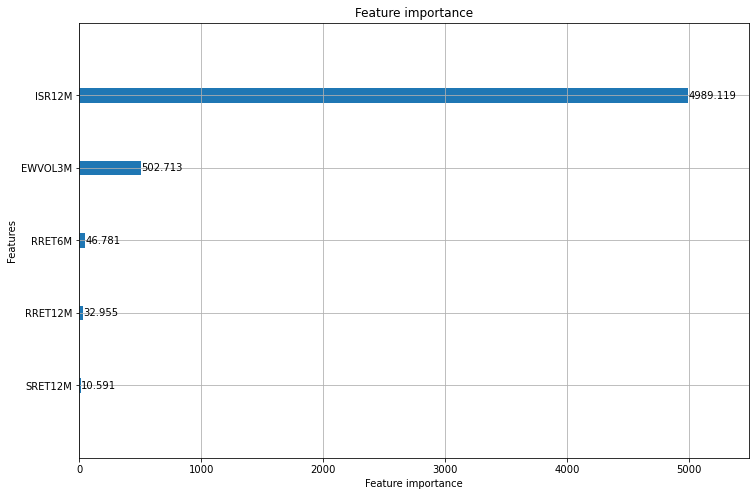

In [68]:
lightgbm.plot_importance(ranker, figsize = (12,8))

In [78]:
predictions = pd.DataFrame(test[["Date","symbols"]])
predictions["gain"] = ranker.predict(X_test)

In [80]:
predictions.groupby("Date")["gain"].agg([np.max, np.min])

,amax,amin
Date,,
2019-01-31,0.399822,-0.420089
2019-02-28,0.399822,-0.420089
2019-03-29,0.399822,-0.420089
2019-04-30,0.399822,-0.420089
2019-05-31,0.355300,-0.420089
2019-06-28,0.399822,-0.420089
2019-07-31,0.399822,-0.420089
2019-08-30,0.399822,-0.420089
2019-09-30,0.399822,-0.420089


In [81]:
predictions

,Date,symbols,gain
63315,2019-01-31,A,-0.346620
63316,2019-01-31,AA,-0.415008
63317,2019-01-31,AAPL,-0.346620
63318,2019-01-31,ABC,-0.394024
63319,2019-01-31,ABT,0.073782
...,...,...,...
83477,2022-07-29,XRX,-0.370026
83478,2022-07-29,Y,-0.259753
83479,2022-07-29,YUM,-0.394024
83480,2022-07-29,ZBH,-0.415008


In [94]:
""" score_predictions = pd.pivot(
    predictions,
    index="Date",
    columns="symbols",
    values="gain"
).rank(axis=1).apply(
    pd.cut, bins=20, labels=False, axis=1
).melt(    
    var_name="symbols",
    value_name="relevance_predicted",
    ignore_index=False
).sort_values(by=["Date","symbols"]) """

In [99]:
score_predictions = pd.pivot(
    predictions,
    index="Date",
    columns="symbols",
    values="gain"
)

In [105]:
score_predictions.iloc[0].value_counts().sort_index()

-0.420089      2
-0.416446      7
-0.415008    100
-0.394024     83
-0.375107      3
-0.371464      5
-0.370498     50
-0.370026      7
-0.346620     62
-0.318595     61
-0.293915     23
-0.259753      1
-0.209166      2
-0.180931      6
-0.133833      1
-0.103063      5
-0.099671      1
 0.073037      2
 0.073782     28
 0.163750      3
 0.164495      2
 0.188632      3
 0.211205      1
 0.265749      4
 0.278007      2
 0.306966      1
 0.355300      2
 0.399822      2
Name: 2019-01-31 00:00:00, dtype: int64

In [95]:
score_predictions.loc["2019-01-31"]["relevance_predicted"].value_counts()

2     100
6      83
12     62
14     61
9      50
18     28
16     23
19     20
17     18
0       9
8       8
10      7
Name: relevance_predicted, dtype: int64